In [1]:
# Install TIMM and relevant libraries
!pip install timm datasets
!pip install wandb

In [2]:
# Import Libraries
import timm
import torch
import torch.nn as nn
from google.colab import drive
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
from torchvision import transforms, datasets, models
import wandb

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Wandb login
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: abdulrahmanabdullahigarba (abdulrahmanabdullahigarba-federal-university-birnin-kebbi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import os
print(os.listdir("/content/drive/MyDrive/NairaNotes"))
print(os.listdir("/content/drive/MyDrive/NairaNotes/Train"))

['Test', 'Train', 'val']
['500', '50', '5', '200', '20', '10', '100', '1000']


In [6]:
# Define the base path to NairaNotes
base_path = '/content/drive/MyDrive/NairaNotes'

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets with the correct transforms
train_dataset = datasets.ImageFolder(root=f"{base_path}/Train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{base_path}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=f"{base_path}/Test", transform=val_test_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Verify the dataset
print("Classes:", train_dataset.classes)
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['10', '100', '1000', '20', '200', '5', '50', '500']
Train samples: 1736
Validation samples: 216
Test samples: 90


In [8]:
print(f"No of 5 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/5').__len__()}")
print(f"No of 10 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/10').__len__()}")
print(f"No of 20 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/20').__len__()}")
print(f"No of 50 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/50').__len__()}")
print(f"No of 100 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/100').__len__()}")
print(f"No of 200 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/200').__len__()}")
print(f"No of 500 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/500').__len__()}")
print(f"No of 1000 Notes: {os.listdir('/content/drive/MyDrive/NairaNotes/Train/1000').__len__()}")

No of 5 Notes: 137
No of 10 Notes: 138
No of 20 Notes: 236
No of 50 Notes: 250
No of 100 Notes: 278
No of 200 Notes: 210
No of 500 Notes: 277
No of 1000 Notes: 210


In [9]:
image, label = train_dataset[10]
image.shape, label

(torch.Size([3, 224, 224]), 0)

In [10]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [11]:
#Setup the model
model_mobilenetv2 = models.mobilenet_v2(pretrained=True).to(device)

#Replacing classifier for the naira dataset
num_classes = len(train_dataset.classes)
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.classifier[1].in_features, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenetv2.parameters(), lr=0.003)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
from sklearn.metrics import classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)
    return {
        "accuracy": (predictions == labels).mean(),
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"]
    }

In [13]:
wandb.init(
    project="naira-classification",
    name="mobilenetv2_run",
    config={
        "model": "MobileNetV2",
        "learning_rate": 0.003,
        "batch_size": 32,
        "epochs": 5,
        "dataset": "Naira",
        "num_classes": num_classes
    }
)

In [14]:
# Training model
def train_model(model, train_loader, val_loader, criterion, device, metrics, scheduler, optimizer, epochs):
    model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        train_loss = train_loss / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss = val_loss / val_total

        # Step learning rate scheduler
        scheduler.step(val_loss)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
        })


        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

In [15]:
train_model(
    model=model_mobilenetv2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
    optimizer=optimizer,
    scheduler=scheduler,
    metrics=compute_metrics,
    epochs=5
)


Epoch 1/5
------------------------------


100%|██████████| 55/55 [06:01<00:00,  6.57s/it]


Train Loss: 0.0209 | Train Acc: 0.7834
Val Loss: 0.0223 | Val Acc: 0.7870

Epoch 2/5
------------------------------


100%|██████████| 55/55 [05:38<00:00,  6.15s/it]


Train Loss: 0.0092 | Train Acc: 0.9142
Val Loss: 0.0207 | Val Acc: 0.7917

Epoch 3/5
------------------------------


100%|██████████| 55/55 [05:17<00:00,  5.77s/it]


Train Loss: 0.0121 | Train Acc: 0.9021
Val Loss: 0.0053 | Val Acc: 0.9398

Epoch 4/5
------------------------------


100%|██████████| 55/55 [05:19<00:00,  5.81s/it]


Train Loss: 0.0075 | Train Acc: 0.9268
Val Loss: 0.0156 | Val Acc: 0.8380

Epoch 5/5
------------------------------


100%|██████████| 55/55 [05:26<00:00,  5.93s/it]


Train Loss: 0.0051 | Train Acc: 0.9516
Val Loss: 0.0162 | Val Acc: 0.8565


In [16]:
import random
def show_random_predictions(model, train_loader, class_names, device, num_samples=7):
    model.eval()
    indices = random.sample(range(len(train_dataset)), num_samples)
    samples = [train_dataset[i] for i in indices]

    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(samples):
        input_img = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
        with torch.no_grad():
            output = model(input_img)
            _, predicted = torch.max(output, 1)

        # Convert image back to displayable format
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np * 0.5 + 0.5, 0, 1)  # Unnormalize if normalized earlier

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_np)
        plt.title(f"Pred: {class_names[predicted.item()]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

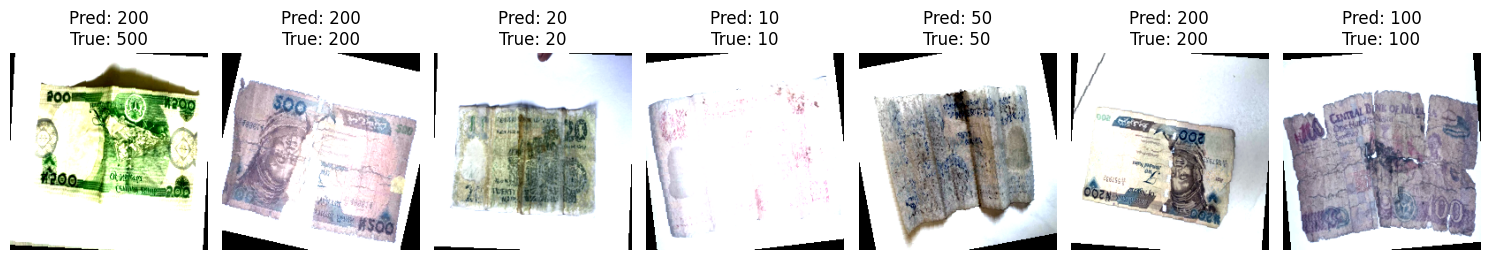

In [17]:
show_random_predictions(model_mobilenetv2, train_loader, train_dataset.classes, device)

In [18]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
            test_total += labels.size(0)

            all_preds.append(outputs.argmax(1).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    test_acc = test_correct / test_total
    test_loss = test_loss / test_total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })

In [19]:
test_model(
    model=model_mobilenetv2,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

Testing: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Test Loss: 0.0193 | Test Accuracy: 0.8667
              precision    recall  f1-score   support

          10       1.00      1.00      1.00         9
         100       1.00      0.83      0.91        12
        1000       0.67      1.00      0.80        12
          20       0.92      1.00      0.96        12
         200       0.71      1.00      0.83        12
           5       1.00      0.78      0.88         9
          50       1.00      0.67      0.80        12
         500       1.00      0.67      0.80        12

    accuracy                           0.87        90
   macro avg       0.91      0.87      0.87        90
weighted avg       0.91      0.87      0.87        90



In [20]:
wandb.finish()

epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▆▇█
train_loss,█▃▄▂▁
val_accuracy,▁▁█▃▄
val_loss,█▇▁▅▅
epoch,5
learning_rate,0.003
test_accuracy,0.86667


In [21]:
import random
def show_random_predictions(model, test_loader, class_names, device, num_samples=5):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)
    samples = [test_dataset[i] for i in indices]

    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(samples):
        input_img = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
        with torch.no_grad():
            output = model(input_img)
            _, predicted = torch.max(output, 1)

        # Convert image back to displayable format
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np * 0.5 + 0.5, 0, 1)  # Unnormalize if normalized earlier

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_np)
        plt.title(f"Pred: {class_names[predicted.item()]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

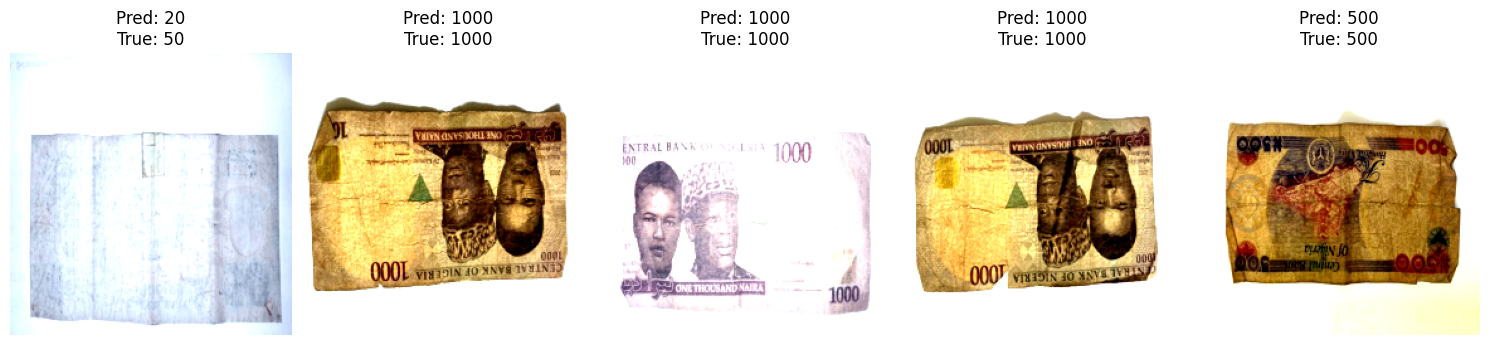

In [22]:
show_random_predictions(model_mobilenetv2, test_loader, test_dataset.classes, device)

In [23]:
# Plot the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, class_names, device, title):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

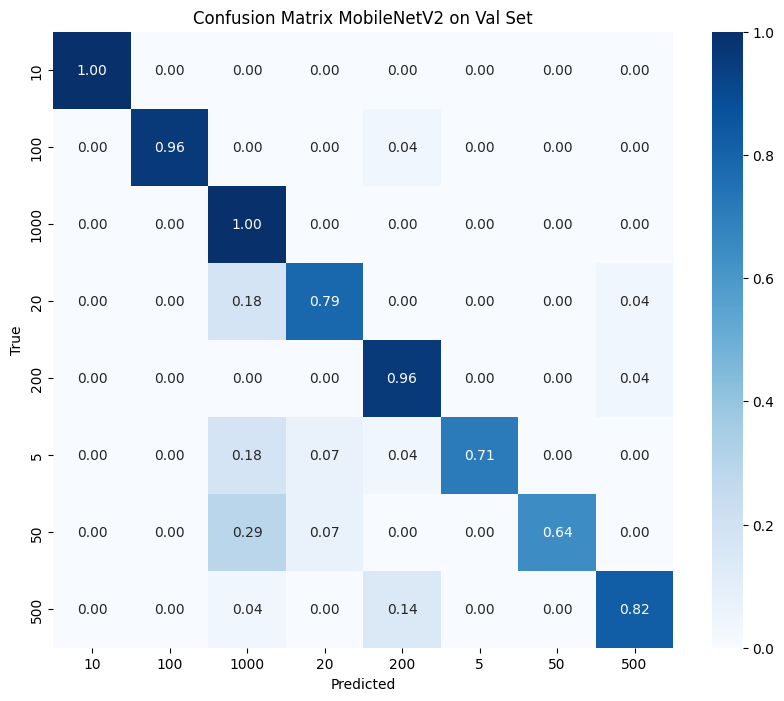

In [24]:
plot_confusion_matrix(model_mobilenetv2, val_loader, train_dataset.classes, device, "Confusion Matrix MobileNetV2 on Val Set")

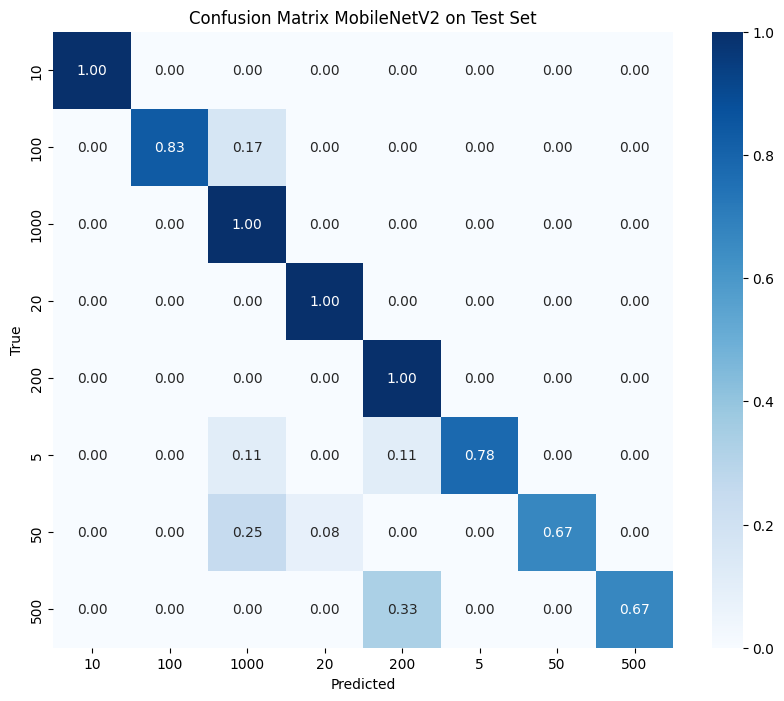

In [25]:
plot_confusion_matrix(model_mobilenetv2, test_loader, test_dataset.classes, device, "Confusion Matrix MobileNetV2 on Test Set")

**Training the MobileNetV3 Model**

In [26]:
# Setup the model with pre-trained ImageNet weights
model_mobilenetv3 = models.mobilenet_v3_small(weights='IMAGENET1K_V1').to(device)

# Freeze the base model to prevent updating pre-trained weights
for param in model_mobilenetv3.parameters():
    param.requires_grad = False

# Replace classifier for the naira dataset
num_classes = len(train_dataset.classes)
model_mobilenetv3.classifier[3] = nn.Linear(model_mobilenetv3.classifier[3].in_features, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenetv3.parameters(), lr=0.003)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [27]:
wandb.init(
    project="naira-classification",
    name="mobilenetv3_run",
    config={
        "model": "MobileNetV2",
        "learning_rate": 0.003,
        "batch_size": 32,
        "epochs": 5,
        "dataset": "Naira",
        "num_classes": num_classes
    }
)

In [28]:
# Training model
def train_model(model, train_loader, val_loader, criterion, device, metrics, scheduler, optimizer, epochs):
    model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / val_total

        # Step learning rate scheduler
        scheduler.step(val_loss)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "val_loss": avg_val_loss,
            "val_accuracy": val_acc,
            "learning_rate": scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
        })


        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

In [29]:
train_model(
    model=model_mobilenetv3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
    optimizer=optimizer,
    scheduler=scheduler,
    metrics=compute_metrics,
    epochs=5
)


Epoch 1/5
------------------------------


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Train Loss: 0.0212 | Train Acc: 0.8358
Val Loss: 0.0294 | Val Acc: 0.6435

Epoch 2/5
------------------------------


100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Train Loss: 0.0075 | Train Acc: 0.9384
Val Loss: 0.0120 | Val Acc: 0.8796

Epoch 3/5
------------------------------


100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


Train Loss: 0.0054 | Train Acc: 0.9591
Val Loss: 0.0066 | Val Acc: 0.9491

Epoch 4/5
------------------------------


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


Train Loss: 0.0042 | Train Acc: 0.9626
Val Loss: 0.0045 | Val Acc: 0.9676

Epoch 5/5
------------------------------


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


Train Loss: 0.0035 | Train Acc: 0.9706
Val Loss: 0.0041 | Val Acc: 0.9769


In [30]:
import random
def show_random_predictions(model, train_loader, class_names, device, num_samples=7):
    model.eval()
    indices = random.sample(range(len(train_dataset)), num_samples)
    samples = [train_dataset[i] for i in indices]

    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(samples):
        input_img = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
        with torch.no_grad():
            output = model(input_img)
            _, predicted = torch.max(output, 1)

        # Convert image back to displayable format
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np * 0.5 + 0.5, 0, 1)  # Unnormalize if normalized earlier

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_np)
        plt.title(f"Pred: {class_names[predicted.item()]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

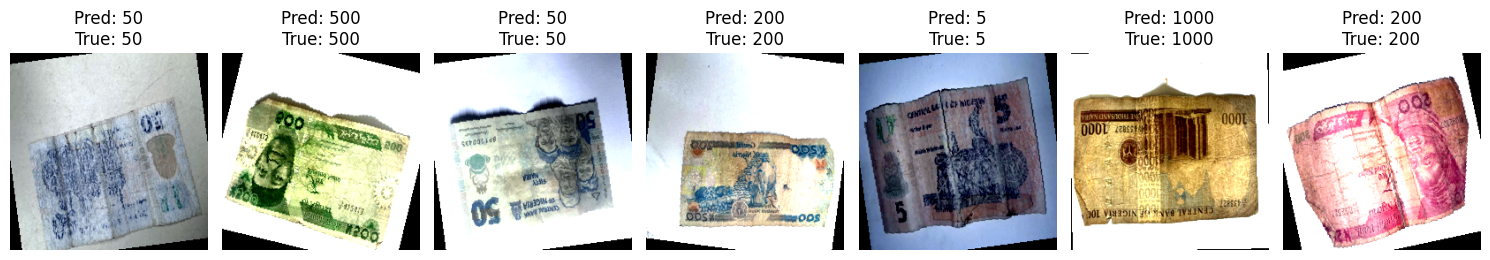

In [31]:
show_random_predictions(model_mobilenetv3, train_loader, train_dataset.classes, device)

In [32]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
            test_total += labels.size(0)

            all_preds.append(outputs.argmax(1).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    test_acc = test_correct / test_total
    test_loss = test_loss / test_total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })

In [33]:
test_model(
    model_mobilenetv3,
    test_loader,
    criterion,
    device
)

Testing: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Test Loss: 0.0080 | Test Accuracy: 0.9111
              precision    recall  f1-score   support

          10       1.00      1.00      1.00         9
         100       0.92      1.00      0.96        12
        1000       1.00      0.83      0.91        12
          20       1.00      0.67      0.80        12
         200       0.86      1.00      0.92        12
           5       1.00      0.89      0.94         9
          50       0.71      1.00      0.83        12
         500       1.00      0.92      0.96        12

    accuracy                           0.91        90
   macro avg       0.94      0.91      0.91        90
weighted avg       0.93      0.91      0.91        90



In [34]:
wandb.finish()

epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
learning_rate,0.003
test_accuracy,0.91111


In [35]:
import random
def show_random_predictions(model, test_loader, class_names, device, num_samples=5):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)
    samples = [test_dataset[i] for i in indices]

    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(samples):
        input_img = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
        with torch.no_grad():
            output = model(input_img)
            _, predicted = torch.max(output, 1)

        # Convert image back to displayable format
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np * 0.5 + 0.5, 0, 1)  # Unnormalize if normalized earlier

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_np)
        plt.title(f"Pred: {class_names[predicted.item()]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

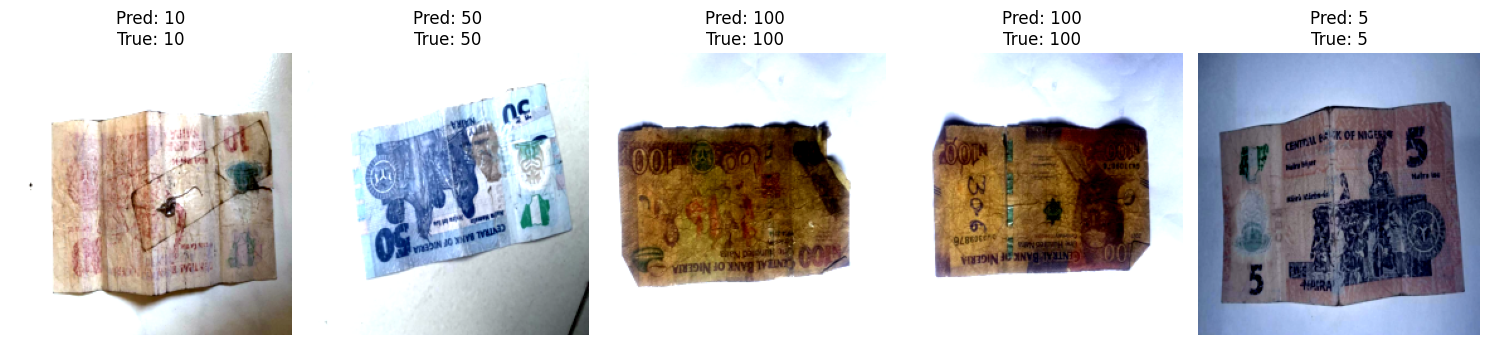

In [36]:
show_random_predictions(
    model_mobilenetv3,
    test_loader,
    test_dataset.classes,
    device)

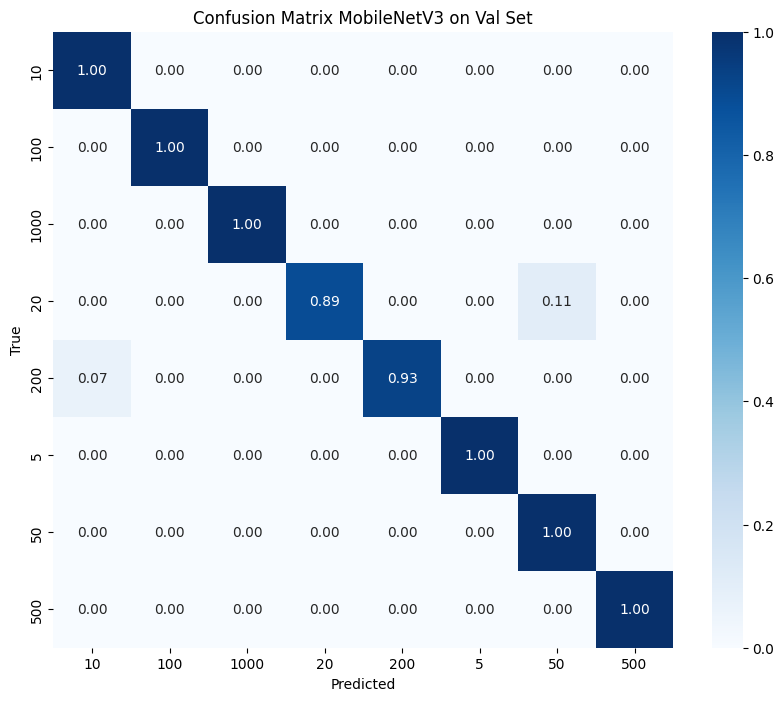

In [37]:
plot_confusion_matrix(model_mobilenetv3, val_loader, train_dataset.classes, device, "Confusion Matrix MobileNetV3 on Val Set")

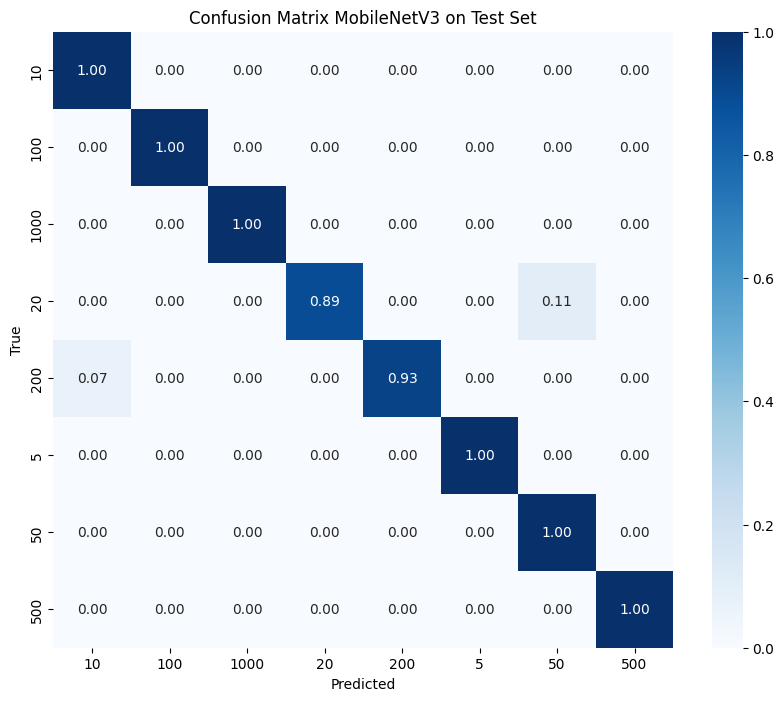

In [38]:
plot_confusion_matrix(model_mobilenetv3, val_loader, train_dataset.classes, device, "Confusion Matrix MobileNetV3 on Test Set")